In [29]:
#Step 1: Install Dependencies
!pip install torch torchvision albumentations opencv-python xmltodict matplotlib

In [30]:
#Step 2: Import Libraries
import os
import cv2
import torch
import torchvision
import numpy as np
import xml.etree.ElementTree as ET
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [ ]:
import os
import torch
import xml.etree.ElementTree as ET
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import numpy as np
import cv2

class PascalVOC_Dataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None, apply_aug=False):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, "JPEGImages")
        self.annotation_dir = os.path.join(root_dir, "Annotations")
        self.split = split
        self.apply_aug = apply_aug
        
        # Define Pascal VOC classes
        self.classes = [
            'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
            'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
            'horse', 'motorbike', 'person', 'pottedplant', 'sheep',
            'sofa', 'train', 'tvmonitor'
        ]
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        # Read image filenames
        split_file = os.path.join(root_dir, "ImageSets", "Main", f"{split}.txt")
        with open(split_file, "r") as f:
            self.image_filenames = [line.strip() for line in f.readlines()]

        # Define Augmentations
        self.augment = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomScale(scale_limit=0.2, p=0.5),
            A.Rotate(limit=20, p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.HueSaturationValue(p=0.5),
            A.GaussNoise(p=0.3),
            A.MotionBlur(blur_limit=5, p=0.3),
            A.Cutout(num_holes=5, max_h_size=50, max_w_size=50, p=0.5),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, f"{filename}.jpg")
        ann_path = os.path.join(self.annotation_dir, f"{filename}.xml")

        # Load image
        image = np.array(Image.open(img_path).convert("RGB"))

        # Parse annotation
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall("object"):
            class_name = obj.find("name").text.lower()
            if class_name not in self.class_to_idx:
                continue
            bbox = obj.find("bndbox")
            boxes.append([
                int(bbox.find("xmin").text),
                int(bbox.find("ymin").text),
                int(bbox.find("xmax").text),
                int(bbox.find("ymax").text)
            ])
            labels.append(self.class_to_idx[class_name])

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        # Apply augmentations
        if self.apply_aug:
            augmented = self.augment(image=image, bboxes=boxes, labels=labels)
            image = augmented['image']
            target["boxes"] = torch.tensor(augmented['bboxes'], dtype=torch.float32)
            target["labels"] = torch.tensor(augmented['labels'], dtype=torch.int64)
        else:
            image = T.ToTensor()(image)

        return image, target


In [32]:
#Step 4: Define DataLoader
transform = T.Compose([T.ToTensor()])
dataset_root = "/kaggle/input/pascal-voc-2007-dataset/VOCdevkit2007/VOC2007"
dataset = PascalVOC_Dataset(root_dir=dataset_root, split="train", transform=transform)

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


In [33]:
def load_faster_rcnn_with_transfer(device="cpu"):
    # Pascal VOC has 20 object classes + 1 background
    num_classes = 21
    
    # Load pre-trained model
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Freeze all layers first
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze last 5 layers of backbone
    for param in model.backbone.body.layer4.parameters():
        param.requires_grad = True
    
    # Unfreeze RPN and ROI heads
    for module in [model.rpn, model.roi_heads]:
        for param in module.parameters():
            param.requires_grad = True
    
    # Replace classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model.to(device)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = load_faster_rcnn_with_transfer(device=device)

# Verify which layers are trainable
print("\nTrainable layers:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)


Trainable layers:
backbone.body.layer4.0.conv1.weight
backbone.body.layer4.0.conv2.weight
backbone.body.layer4.0.conv3.weight
backbone.body.layer4.0.downsample.0.weight
backbone.body.layer4.1.conv1.weight
backbone.body.layer4.1.conv2.weight
backbone.body.layer4.1.conv3.weight
backbone.body.layer4.2.conv1.weight
backbone.body.layer4.2.conv2.weight
backbone.body.layer4.2.conv3.weight
rpn.head.conv.0.0.weight
rpn.head.conv.0.0.bias
rpn.head.cls_logits.weight
rpn.head.cls_logits.bias
rpn.head.bbox_pred.weight
rpn.head.bbox_pred.bias
roi_heads.box_head.fc6.weight
roi_heads.box_head.fc6.bias
roi_heads.box_head.fc7.weight
roi_heads.box_head.fc7.bias
roi_heads.box_predictor.cls_score.weight
roi_heads.box_predictor.cls_score.bias
roi_heads.box_predictor.bbox_pred.weight
roi_heads.box_predictor.bbox_pred.bias


In [8]:
# Step 6: Train Faster R-CNN (3 epochs) and Save Final Model
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
scaler = torch.cuda.amp.GradScaler()
num_epochs = 3  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():  
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += losses.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(data_loader):.4f}")

# Save the final model after training
torch.save(model.state_dict(), "fasterrcnn_final_model.pth")
print("Training complete! Final model saved to faster_rcnn.pth")

<ipython-input-8-8e340c4823ce>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-8-8e340c4823ce>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/3], Loss: 0.3331
Epoch [2/3], Loss: 0.2599
Epoch [3/3], Loss: 0.2222
Training complete! Final model saved to fasterrcnn_final_model.pth


In [9]:
#Step 7: Evaluate Faster R-CNN
def evaluate_faster_rcnn(model, dataloader, device):
    model.eval()
    all_preds, all_gts = [], []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes = output["boxes"].cpu()
                pred_scores = output["scores"].cpu()
                gt_boxes = target["boxes"].cpu()

                all_preds.append((pred_boxes, pred_scores))
                all_gts.append(gt_boxes)

    return all_preds, all_gts


In [10]:
# Compute mAP for Faster R-CNN
def calculate_map_faster_rcnn(all_preds, all_gts, iou_threshold=0.5):
    if not all_preds or not all_gts:
        print("No valid predictions or ground truths available.")
        return 0.0

    all_ap = []
    for (pred_boxes, pred_scores), gt_boxes in zip(all_preds, all_gts):
        if len(gt_boxes) == 0:
            continue

        ious = torchvision.ops.box_iou(pred_boxes, gt_boxes)
        matches = ious > iou_threshold

        tp = torch.zeros(len(pred_boxes))
        fp = torch.zeros(len(pred_boxes))

        for i, match in enumerate(matches):
            if match.any():
                tp[i] = 1
            else:
                fp[i] = 1

        tp_cumsum = torch.cumsum(tp, dim=0)
        fp_cumsum = torch.cumsum(fp, dim=0)

        precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
        recall = tp_cumsum / len(gt_boxes)

        ap = torch.trapz(precision, recall)
        all_ap.append(ap.item())

    return sum(all_ap) / len(all_ap) if all_ap else 0.0


In [11]:
#Step 8: Run Evaluation
all_preds, all_gts = evaluate_faster_rcnn(model, data_loader, device)

if all_preds and all_gts:
    map_score = calculate_map_faster_rcnn(all_preds, all_gts)
    print(f"Mean Average Precision (mAP): {map_score:.4f}")
else:
    print("Evaluation failed .")

Mean Average Precision (mAP): 0.5301


In [35]:
MODEL_PATH="/kaggle/input/faster-rcnn-without-aug/faster_rcnn.pth"
model = load_faster_rcnn_with_transfer( device="cpu")
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

<ipython-input-35-d2b088370d5c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


<All keys matched successfully>

In [14]:
import time
import numpy as np
import torch
from sklearn.metrics import precision_recall_fscore_support  

In [16]:
import time

def calculate_fps(model, dataloader, device, num_batches=50):
    """Calculate FPS for Faster R-CNN model"""
    model.eval()
    
    # Warmup
    with torch.no_grad():
        for i, (images, _) in enumerate(dataloader):
            if i >= 2:  # 2 warmup batches
                break
            images = [img.to(device) for img in images]
            _ = model(images)
    
    # Timed measurement
    start_time = time.time()
    with torch.no_grad():
        for i, (images, _) in enumerate(dataloader):
            if i >= num_batches:
                break
            images = [img.to(device) for img in images]
            _ = model(images)
    
    fps = num_batches / (time.time() - start_time)
    return fps

# Usage:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fps = calculate_fps(model, data_loader, device)
print(f"FPS: {fps:.1f}")

FPS: 3.3


In [41]:
dataset = PascalVOC_Dataset(root_dir="/kaggle/input/pascal-voc-2007-dataset/VOCdevkit2007/VOC2007", split="train")
print("Class to index mapping:", dataset.class_to_idx)

# Check first sample
sample, target = dataset[0]
print("Sample labels:", target["labels"])
print("Class names:", [dataset.classes[i] for i in target["labels"].tolist()])

Class to index mapping: {'background': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}
Sample labels: tensor([7])
Class names: ['car']


In [42]:
def visualize_predictions(image, prediction, target, confidence_thresh=0.5):
    """Enhanced visualization with prediction validation"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Ground Truth
    ax1.imshow(image)
    for box, label in zip(target['boxes'], target['labels']):
        x1, y1, x2, y2 = box.tolist()
        ax1.add_patch(plt.Rectangle(
            (x1, y1), x2-x1, y2-y1, fill=False, edgecolor='green', linewidth=2
        ))
        ax1.text(x1, y1, dataset.classes[label], color='white', 
                bbox=dict(facecolor='green', alpha=0.7))
    ax1.set_title("Ground Truth")
    
    # Predictions
    ax2.imshow(image)
    keep = prediction['scores'] > confidence_thresh
    pred_labels = prediction['labels'][keep].tolist()
    pred_scores = prediction['scores'][keep].tolist()
    
    for box, label, score in zip(prediction['boxes'][keep], pred_labels, pred_scores):
        x1, y1, x2, y2 = box.tolist()
        ax2.add_patch(plt.Rectangle(
            (x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2
        ))
        ax2.text(x1, y1, f"{dataset.classes[label]}:{score:.2f}", 
                color='white', bbox=dict(facecolor='red', alpha=0.7))
    ax2.set_title("Predictions")
    
    # Debug info
    print("\nPrediction Analysis:")
    print("Predicted classes:", [dataset.classes[l] for l in pred_labels])
    print("Confidence scores:", pred_scores)
    
    plt.show()


Prediction Analysis:
Predicted classes: ['chair', 'chair', 'chair', 'chair', 'tvmonitor']
Confidence scores: [0.997475802898407, 0.9565898180007935, 0.9456262588500977, 0.8103421330451965, 0.7423129677772522]


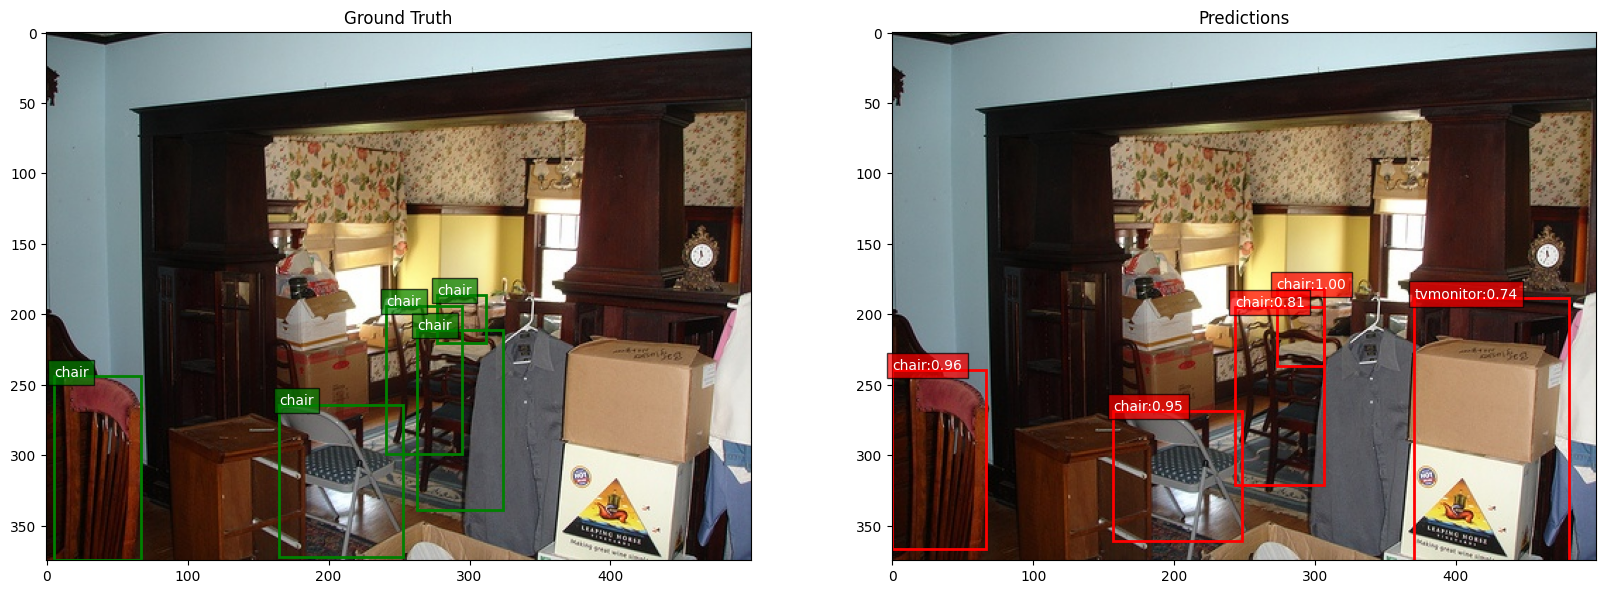

In [43]:
# 1. First prepare your model and dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = PascalVOC_Dataset(root_dir="/kaggle/input/pascal-voc-2007-dataset/VOCdevkit2007/VOC2007", split="val")  # or "train"

# 2. Select a sample to visualize
sample_idx = 0  # Change this to see different images
sample_image, sample_target = dataset[sample_idx]

# 3. Prepare the model for inference
model.eval()

# 4. Make prediction
with torch.no_grad():
    # Convert image to tensor and add batch dimension
    if isinstance(sample_image, torch.Tensor):
        input_tensor = sample_image.unsqueeze(0).to(device)
    else:
        input_tensor = transform(sample_image).unsqueeze(0).to(device)
    
    # Get prediction
    prediction = model(input_tensor)[0]  # Remove batch dimension

# 5. Call visualization function
visualize_predictions(
    image=sample_image, 
    prediction=prediction, 
    target=sample_target,
    confidence_thresh=0.7  # Adjust threshold as needed
)